## San Francisco Restaurant Health Scores and Violations

This dataset was pulled from Kaggle. The link to can be found [here](https://www.kaggle.com/san-francisco/sf-restaurant-scores-lives-standard).

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns

#notification magic
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [87]:
df = pd.read_csv('restaurant-scores-lives-standard.csv')

In [88]:
import calendar
df['inspection_date'] = pd.to_datetime(df['inspection_date'])


df['Year'] = df['inspection_date'].dt.year
df['Month'] = df['inspection_date'].dt.month
df['Date'] = df['inspection_date'].dt.day
df['Day'] = df['inspection_date'].apply(lambda x: calendar.day_name[x.weekday()])

In [89]:
df = df.drop(columns=['business_id', 'business_phone_number', 'business_city', 'business_state', 'business_location', 'inspection_id', 'business_address'])

In [90]:
df.shape

(53732, 20)

In [91]:
df.dropna(inplace=True)

In [92]:
df.shape

(21443, 20)

In [93]:
#load our dataset
yelp_df = pd.read_csv('yelp_business.csv')

In [94]:
yelp_df.rename(columns={'id' : 'yelp_id', 'rating' : 'yelp_rating'}, inplace=True)

In [95]:
yelp_df.dropna(how='all', inplace=True)

In [96]:
#convert our '$' values into a numeric measure
yelp_df.price = yelp_df.price.apply(lambda x: len(x) if type(x) != float else np.nan)

In [97]:
df = df.merge(yelp_df, how='left', left_on='business_name', right_on='name')

In [98]:
null = df.isnull().sum() / len(df) * 100
null[null > 0]

name                65.933625
yelp_id             65.933625
yelp_rating         65.933625
price               67.481488
review_rating       65.933625
review_sentiment    65.933625
dtype: float64

In [99]:
df.shape

(22418, 26)

In [100]:
df.dropna(inplace=True)

In [101]:
df.shape

(7290, 26)

In [102]:
numeric_columns = df.select_dtypes(include=['float64'])
cat_cols = df.loc[:, ~df.columns.isin(numeric_columns)]
numeric_columns = numeric_columns.drop(columns=['business_latitude', 'business_longitude'])
cat_cols = cat_cols.drop(columns=['inspection_date', 'violation_id', 'business_name', 'name', 'yelp_id'])

Correlation: 1.0 -- p_value: 0.0


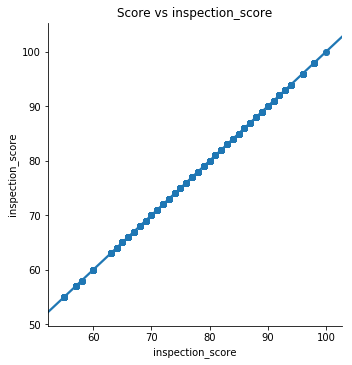

Correlation: 0.09459685081464037 -- p_value: 5.793150795568325e-16


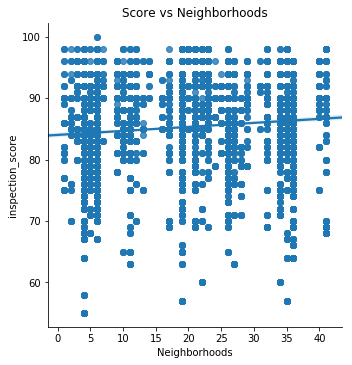

Correlation: 0.032666226881829866 -- p_value: 0.005281274355280502


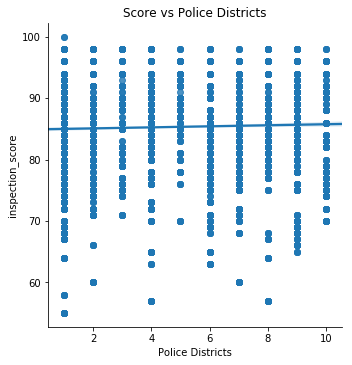

Correlation: 0.02173268865835038 -- p_value: 0.0635290803169959


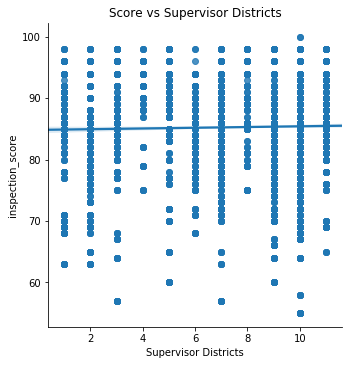

Correlation: 0.03891919699967066 -- p_value: 0.000888416921588262


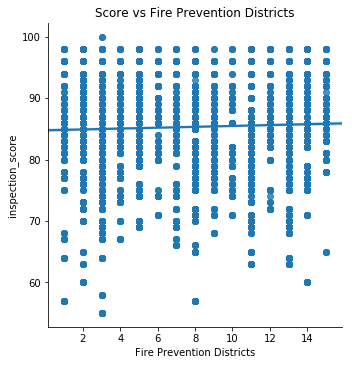

Correlation: -0.03386756009574731 -- p_value: 0.003828019869275996


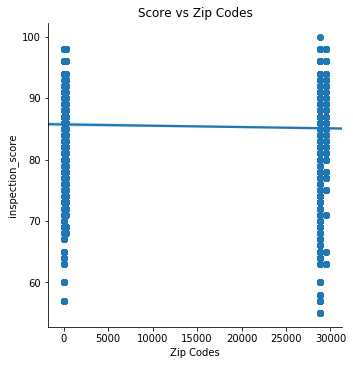

Correlation: 0.0707501198216856 -- p_value: 1.4729884643789997e-09


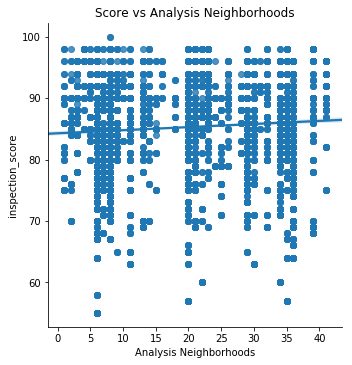

Correlation: 0.12426994081772927 -- p_value: 1.7466931055567082e-26


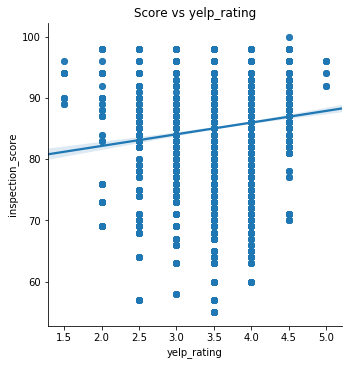

Correlation: 0.0760415088073497 -- p_value: 7.987382809972449e-11


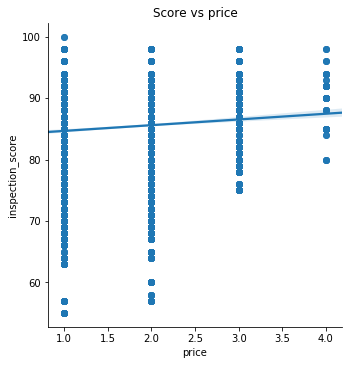

Correlation: 0.08736843310586342 -- p_value: 7.858935965110469e-14


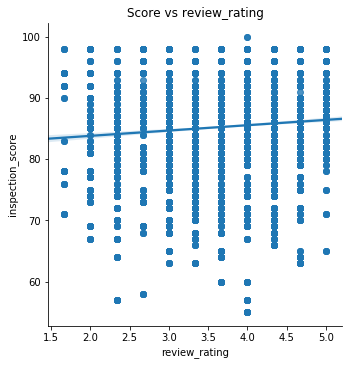

Correlation: 0.14097565647449797 -- p_value: 1.1211087210534037e-33


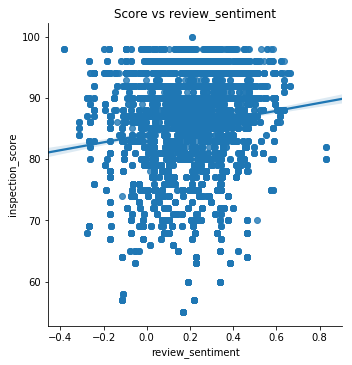

In [23]:
for column in numeric_columns:
    corr, p_value = stats.pearsonr(df[column], df.inspection_score)
    print('Correlation: {} -- p_value: {}'.format(corr, p_value))
    
    sns.lmplot(x=column, y='inspection_score', data=df)
    plt.title('Score vs {}'.format(column))
    plt.show()

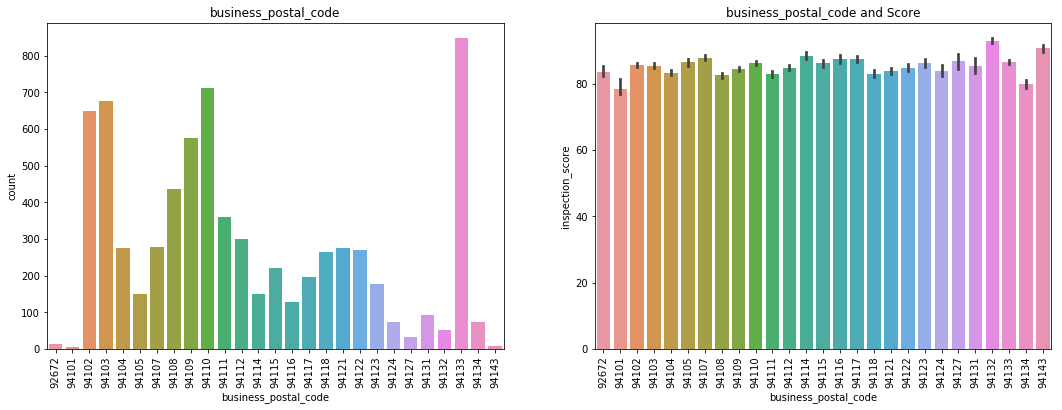

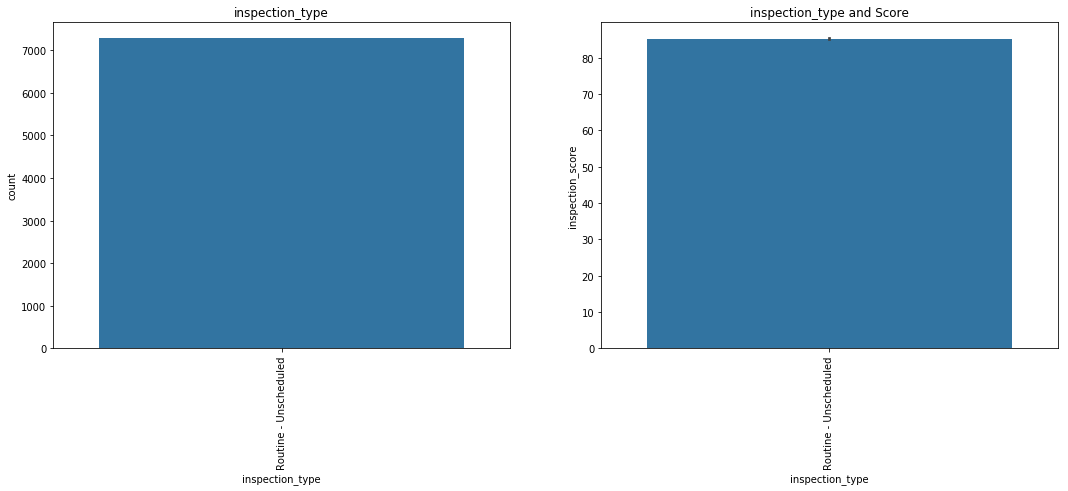

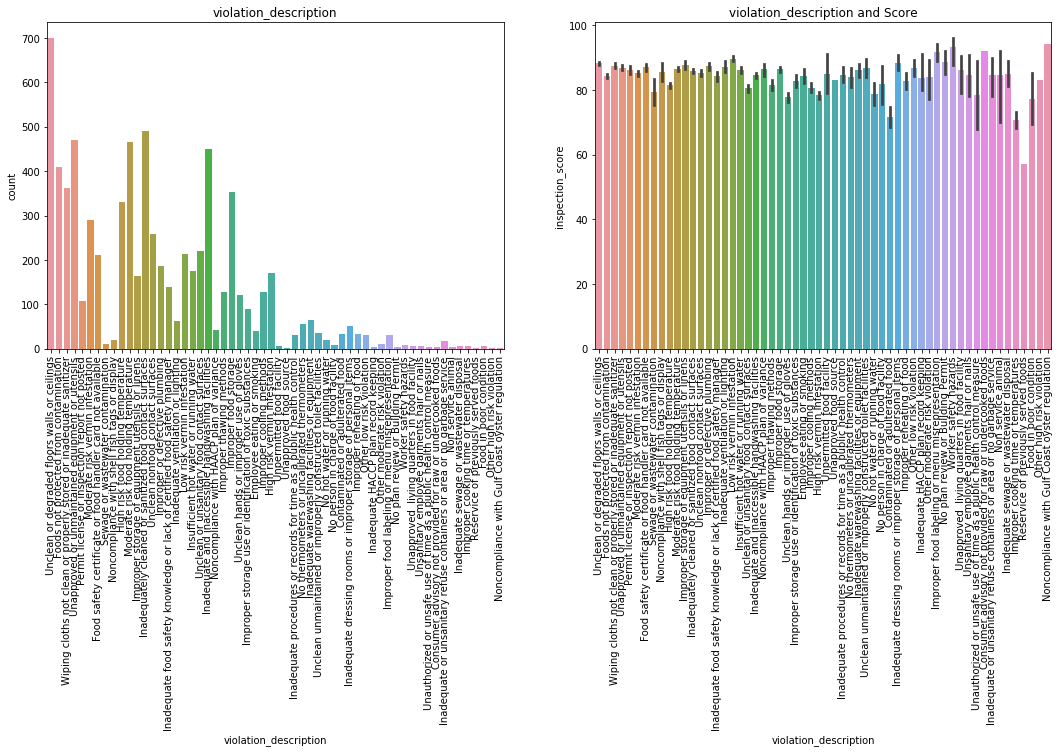

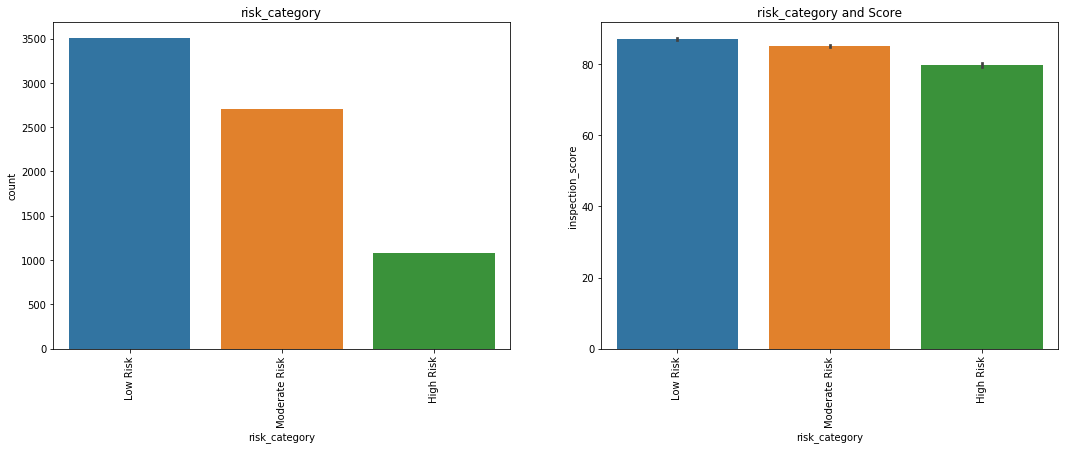

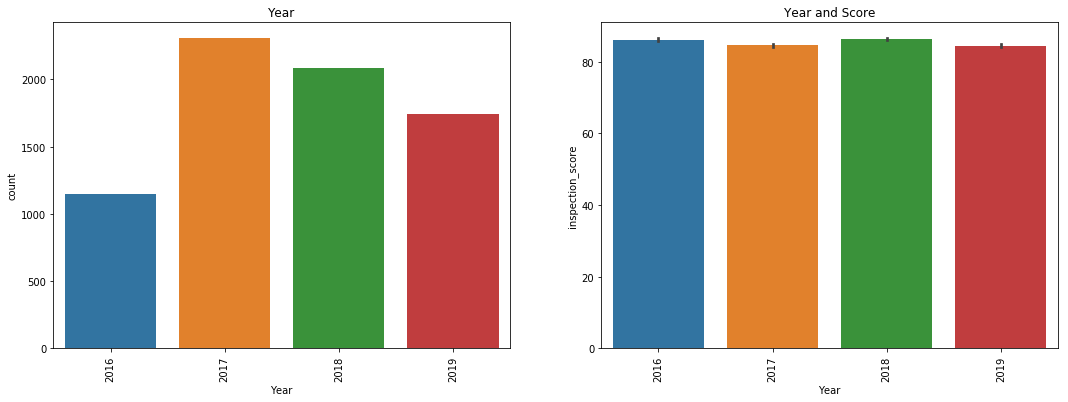

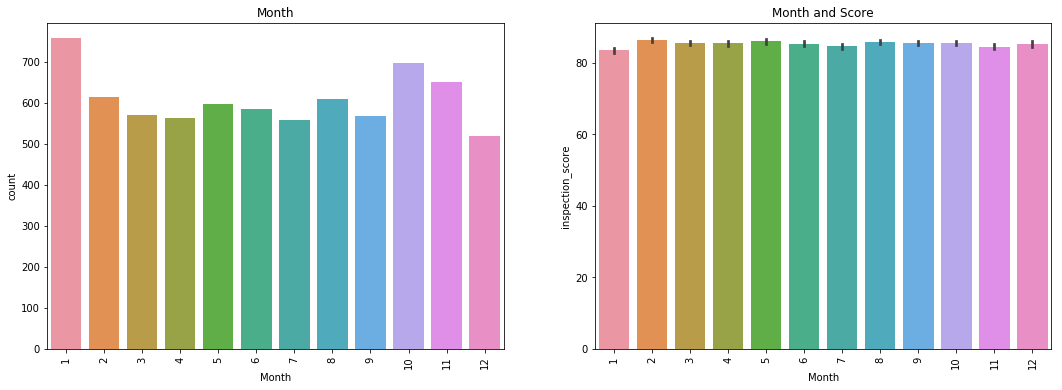

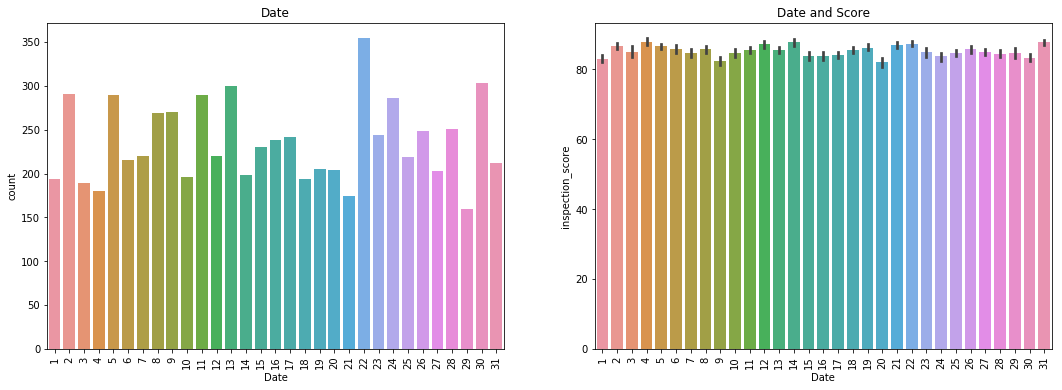

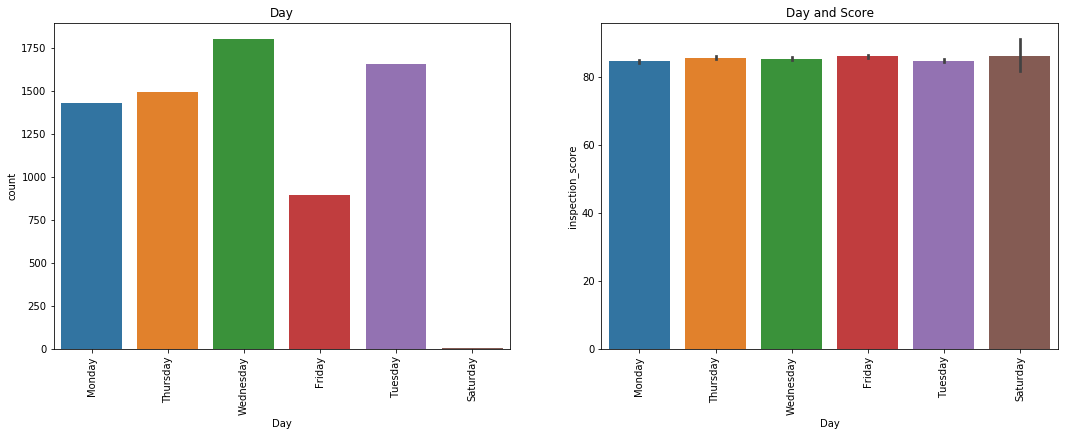

In [34]:
for column in cat_cols:
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    sns.countplot(df[column])
    plt.xticks(rotation='vertical')
    plt.title('{}'.format(column))
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=column, y='inspection_score', data=df)
    plt.title('{} and Score'.format(column))
    plt.xticks(rotation='vertical')
    plt.show()

In [130]:
postal_code = pd.get_dummies(df['business_postal_code'], drop_first=True)
violation_description = pd.get_dummies(df['violation_description'], drop_first=True)
risk_category = pd.get_dummies(df['risk_category'], drop_first=True)
day = pd.get_dummies(df['Day'], drop_first=True)
name = pd.get_dummies(df['business_name'], drop_first=True)

dummies_df = pd.concat([postal_code, violation_description, day, name], axis=1)

In [131]:
X = pd.concat([numeric_columns, cat_cols.loc[:, ['Year', 'Month', 'Date']], dummies_df, df.loc[:, ['business_longitude', 'business_latitude']]], axis=1) 
X = X.drop(columns=['inspection_score'])
Y = df['inspection_score']

### Random Forest Model

In [132]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

In [133]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

## Tune estimators

In [54]:
%%notify

ranges = np.arange(1, 200, 10)
averages = []
for i in ranges:
    rfr = ensemble.RandomForestRegressor(n_estimators=i)
    rfr.fit(X_train, y_train)
    scores = cross_val_score(rfr, X_test, y_test, cv=5)
    averages.append(scores.mean())

<IPython.core.display.Javascript object>

In [55]:
print('{} -- {}'.format(max(averages), averages.index(max(averages)) + 1))

0.6048474968108797 -- 15


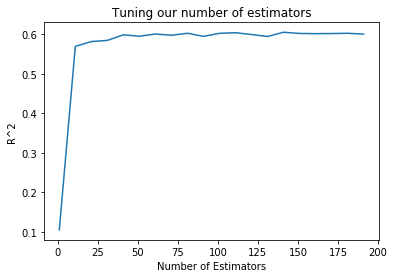

In [56]:
plt.plot(ranges, averages)
plt.title('Tuning our number of estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2')
plt.show()

In [134]:
%%notify
rfr = ensemble.RandomForestRegressor(n_estimators=15, max_features='sqrt')
rfr.fit(X_train, y_train)

scores = cross_val_score(rfr, X_test, y_test, cv=5)
print(scores)
print('The average score is {}'.format(scores.mean()))
print('The std is {}'.format(scores.std()))

[0.52492907 0.52149294 0.57863813 0.51835651 0.60392366]
The average score is 0.5494680613040961
The std is 0.0351255005664462


<IPython.core.display.Javascript object>

In [135]:
rfr.score(X_test, y_test)

0.9172866154918318

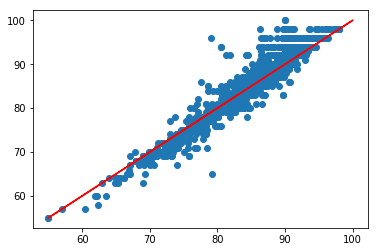

In [136]:
y_preds = rfr.predict(X_test)

plt.scatter(y_preds, y_test)
plt.plot(y_test, y_test, color='red')
plt.show()

In [110]:
columns = X_test.columns
feature_importances = rfr.feature_importances_

rfr_features = pd.DataFrame()
rfr_features['features'] = columns
rfr_features['importance'] = feature_importances

rfr_features = rfr_features.sort_values(by='importance', ascending=False).reset_index()
rfr_features.head(20)

,index,features,importance
0,773,business_latitude,0.059907
1,12,Date,0.057874
2,9,review_sentiment,0.054454
3,772,business_longitude,0.048926
4,11,Month,0.048717
5,5,Analysis Neighborhoods,0.040892
6,10,Year,0.035648
7,8,review_rating,0.033798
8,6,yelp_rating,0.032130
9,0,Neighborhoods,0.028414


In [111]:
features = rfr_features['features'][:20]

### Decision Tree

In [28]:
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

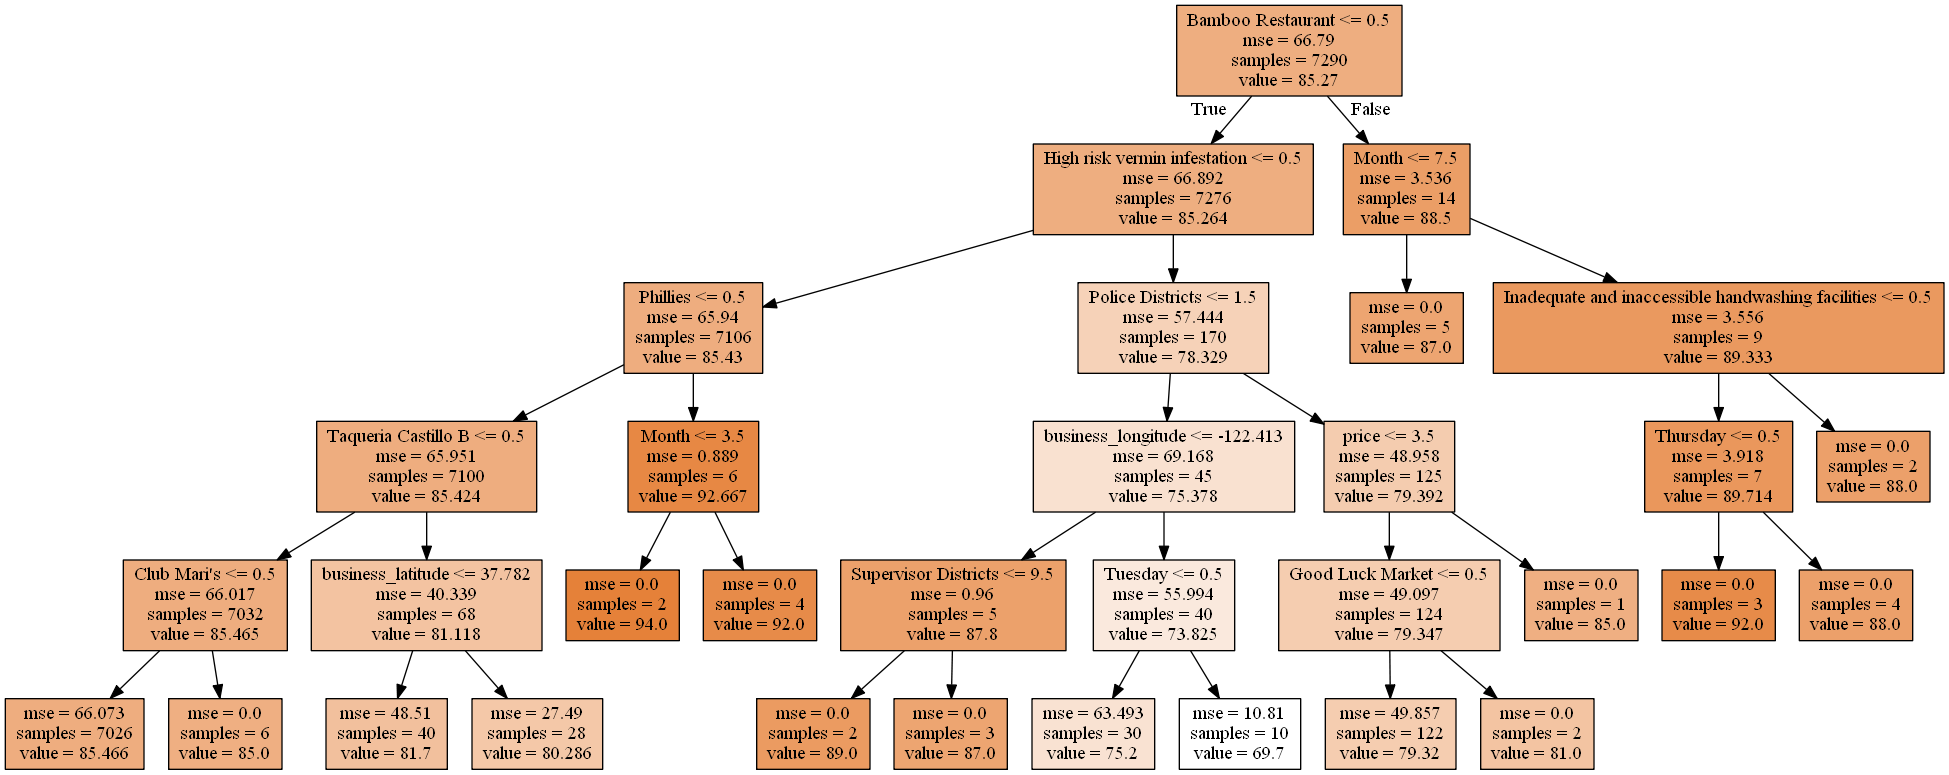

In [29]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeRegressor(max_features=1, max_depth=5,)

decision_tree.fit(X, Y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [30]:
scores = cross_val_score(decision_tree, X, Y, cv=10)
print('Array: {}'.format(scores))
print('Mean: {}'.format(scores.mean()))
print('Standard Deviation: {}'.format(scores.std()))

Array: [-1.44960143e-01 -8.95413211e-03 -1.09276324e-02 -9.53847732e-03
  2.83296367e-03 -1.75485778e-02 -3.49155053e-03 -1.05897197e-02
 -7.10401261e-06  1.46313861e-04]
Mean: -0.020303805962092726
Standard Deviation: 0.041978450108152814


<IPython.core.display.Javascript object>

### Gradient Boosting Regressor

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [113]:
%%notify
gbr = ensemble.GradientBoostingRegressor()

gbr.fit(X_train, y_train)

scores = cross_val_score(gbr, X_test, y_test, cv=5)
print(scores)
print('The average score is {}'.format(scores.mean()))
print('The std is {}'.format(scores.std()))

[0.3057164  0.35532932 0.39152865 0.28750724 0.37681006]
The average score is 0.34337833139000906
The std is 0.040296302237990016


<IPython.core.display.Javascript object>

In [114]:
gbr.score(X_test, y_test)

0.42024588881610614

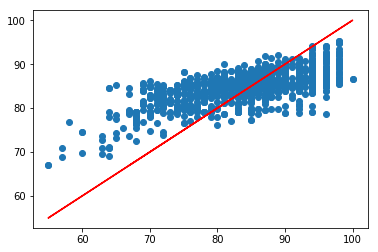

In [115]:
y_preds = gbr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.show()

### Lasso Regression

In [116]:
%%notify
from sklearn.linear_model import Lasso

averages = []
for i in range(1, 100):
    lassoregr = Lasso(alpha=10**i) 
    averages.append(cross_val_score(lassoregr, X, Y, scoring='neg_mean_squared_error', cv=10).mean())

print('Highest mean: {} -- Parameter: {}'.format(max(averages), averages.index(max(averages)) + 1))

Highest mean: -66.9902796010808 -- Parameter: 1


<IPython.core.display.Javascript object>

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [122]:
lassoregr = Lasso(alpha=10**1) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.00120652326988957
-----Test set statistics-----
Mean absolute percentage error of the prediction is: 7.960504213291286


### Linear Regression

In [79]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

C:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:       inspection_score   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     20.95
Date:                Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:38:54   Log-Likelihood:                -16416.
No. Observations:                5832   AIC:                         3.434e+04
Df Residuals:                    5076   BIC:                         3.939e+04
Df Model:                         755                                         
Covariance Type:            nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [138]:
from sklearn.linear_model import LinearRegression

lrm = LinearRegression()

lrm.fit(X_train, y_train)

lrm.score(X_test, y_test)

-93394287523.94771

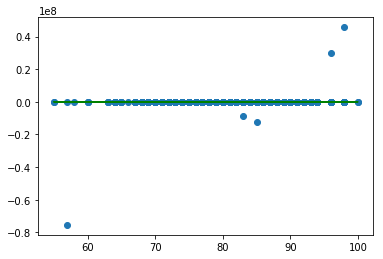

In [139]:
y_preds = lrm.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='green')
plt.show()

# LRM w/  certain number of features. Pulled from top R^2 values

In [46]:
r_squared = []
columns = []
for column in numeric_columns:
    corr, p_value = stats.pearsonr(df['inspection_score'], df[column])
    columns.append(column)
    r_squared.append(corr)

r_df = pd.DataFrame()
r_df['columns'] = columns
r_df['r_2'] = r_squared

In [47]:
r_df = r_df.sort_values(by='r_2', ascending=False).reset_index()

In [48]:
r_df

,index,columns,r_2
0,0,inspection_score,1.000000
1,10,review_sentiment,0.140976
2,7,yelp_rating,0.124270
3,1,Neighborhoods,0.094597
4,9,review_rating,0.087368
5,8,price,0.076042
6,6,Analysis Neighborhoods,0.070750
7,4,Fire Prevention Districts,0.038919
8,2,Police Districts,0.032666
9,3,Supervisor Districts,0.021733


In [58]:
features = r_df['columns'][:4].to_list()
features.remove('inspection_score')

In [59]:
postal_code = pd.get_dummies(df['business_postal_code'], drop_first=True)
violation_description = pd.get_dummies(df['violation_description'], drop_first=True)
risk_category = pd.get_dummies(df['risk_category'], drop_first=True)
day = pd.get_dummies(df['Day'], drop_first=True)
name = pd.get_dummies(df['business_name'], drop_first=True)

dummies_df = pd.concat([postal_code, violation_description, day, name], axis=1)

In [67]:
X = pd.concat([dummies_df, df[features]], axis=1)
y = df['inspection_score']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [69]:
lrm.fit(X_train, y_train)

lrm.score(X_test, y_test)

0.6870972670381968

In [70]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

C:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:       inspection_score   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     20.64
Date:                Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:32:44   Log-Likelihood:                -16489.
No. Observations:                5832   AIC:                         3.447e+04
Df Residuals:                    5088   BIC:                         3.943e+04
Df Model:                         743                                         
Covariance Type:            nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [71]:
scores = cross_val_score(lrm, X, y, cv=10)
print(scores)
print('Mean: {} -- STD: {}'.format(scores.mean(), scores.std()))

[-3.87788897e+12  6.86600142e-01  7.64123600e-01 -4.21040307e+05
 -2.03968402e+15  7.44194673e-01 -3.93196785e+14 -2.78913037e+17
 -4.85983525e+14 -4.68218560e+14]
Mean: -2.8230399824663896e+16 -- STD: 8.356296911119598e+16


## Let's work on predicting our sentiment scores.

#### We should do this without the rating reviews, maybe?

In [98]:
df.columns

Index(['business_name', 'business_postal_code', 'business_latitude',
       'business_longitude', 'inspection_date', 'inspection_score',
       'inspection_type', 'violation_id', 'violation_description',
       'risk_category', 'Neighborhoods', 'Police Districts',
       'Supervisor Districts', 'Fire Prevention Districts', 'Zip Codes',
       'Analysis Neighborhoods', 'Year', 'Month', 'Date', 'Day', 'name',
       'yelp_id', 'yelp_rating', 'price', 'review_rating', 'review_sentiment'],
      dtype='object')

In [117]:
X = pd.concat([numeric_columns, cat_cols.loc[:, ['Year', 'Month', 'Date']], dummies_df, df.loc[:, ['business_longitude', 'business_latitude']]], axis=1) 
X = X.drop(columns=['review_sentiment', 'review_rating', 'yelp_rating'])
y = df['review_sentiment']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [119]:
rfr = ensemble.RandomForestRegressor()

rfr.fit(X_train, y_train)

rfr.score(X_test, y_test)

C:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8301564236530267

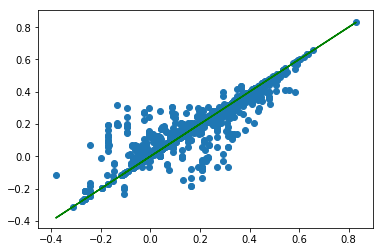

In [120]:
y_preds = rfr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='green')
plt.show()

In [121]:
columns = X_test.columns
feature_importances = rfr.feature_importances_

rfr_features = pd.DataFrame()
rfr_features['features'] = columns
rfr_features['importance'] = feature_importances

rfr_features = rfr_features.sort_values(by='importance', ascending=False).reset_index()
rfr_features.head(20)

,index,features,importance
0,770,business_longitude,0.105411
1,771,business_latitude,0.079052
2,0,inspection_score,0.050471
3,6,Analysis Neighborhoods,0.041042
4,10,Date,0.025145
5,424,Lee's Deli,0.020493
6,7,price,0.019886
7,656,Sushirrito,0.018956
8,9,Month,0.017293
9,644,Sunrise Deli,0.015703


## Let's try some PCA w/ SVM and LRM

C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


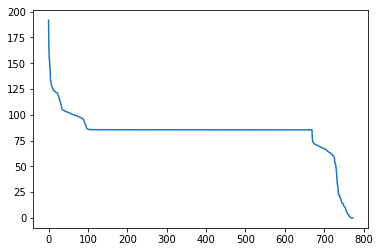

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
Xt = scaler.fit_transform(X)

pca = PCA()

pca.fit(Xt)

plt.plot(pca.singular_values_)
plt.show()

In [29]:
Xp = pca.transform(X)[:, 0:100]

In [31]:
y = df['inspection_score']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.2, random_state=10)

In [34]:
from sklearn.linear_model import LinearRegression


lrm = LinearRegression()
lrm.fit(X_train, y_train)

lrm.score(X_test, y_test)

0.28627473102671996

In [36]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train,y_train)

svr.score(X_test, y_test)

C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.18874863974720876